In [1]:
import os
import cv2
import numpy as np
from collections import defaultdict

import scikitplot
import seaborn as sns
from matplotlib import pyplot

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling3D, GlobalMaxPool3D
from tensorflow.keras.layers import TimeDistributed, LSTM, Bidirectional, ConvLSTM2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau

from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

Using TensorFlow backend.


In [2]:
INPUT_PATH = "../input/ck48-5-emotions/CK+48/"

for dir_ in os.listdir(INPUT_PATH):
    count = 0
    for f in os.listdir(INPUT_PATH + dir_ + "/"):
        count += 1
    print(f"{dir_} has {count} number of images")

anger has 135 number of images
fear has 75 number of images
surprise has 249 number of images
sadness has 84 number of images
happy has 207 number of images


`sadness` and `fear` has very low number of images as compared to other classes

In [3]:
TOP_EMOTIONS = ["happy", "surprise", "anger", "sadness", "fear"]

### Data Preprocessing

I first make the data compatible for the model.

In [4]:
INPUT_PATH = "../input/ck48-5-emotions/CK+48/"

data = defaultdict(str)
for dir_ in os.listdir(INPUT_PATH):
    if dir_ in TOP_EMOTIONS:
        data[dir_] = defaultdict(list)
        for f in os.listdir(INPUT_PATH + dir_ + "/"):
            sub = f.split("_")[0]
            data[dir_][sub].append(f)

# data

In [5]:
def preprocess_list(x):
    return int((x.split("_")[2]).split(".")[0])

def preprocess_dict(x):
    res = list(np.argsort(list(map(preprocess_list, x))))
    return [x[i] for i in res]

def img2array(x,path):
    arr = np.empty(shape=(3,48,48))
    for i,f in enumerate(x):
        img = cv2.imread(path+f, 0)
        arr[i] = img
    return arr

In [6]:
for emotion in data:
    data[emotion] = dict((k, preprocess_dict(v)) for k, v in data[emotion].items())
    data[emotion] = dict((k, img2array(v, path=INPUT_PATH + emotion + "/")) for k, v in data[emotion].items())

# data

In [7]:
for k,v in data.items():
    print(f"{k} has {len(v)} samples")

anger has 45 samples
fear has 25 samples
surprise has 83 samples
sadness has 28 samples
happy has 69 samples


In [8]:
surprise = np.stack(data["surprise"].values(), axis=0)
surprise = surprise.reshape(*surprise.shape,1)

happy = np.stack(data["happy"].values(), axis=0)
happy = happy.reshape(*happy.shape,1)

anger = np.stack(data["anger"].values(), axis=0)
anger = anger.reshape(*anger.shape,1)

sadness = np.stack(data["sadness"].values(), axis=0)
sadness = sadness.reshape(*sadness.shape,1)

fear = np.stack(data["fear"].values(), axis=0)
fear = fear.reshape(*fear.shape,1)

X = np.concatenate((surprise, happy, anger, sadness, fear))
y = np.concatenate((np.array([0]*83), np.array([1]*69), np.array([2]*45), np.array([3]*28), np.array([4]*25)))

# X = np.concatenate((surprise, happy, anger, sadness, fear, surprise, happy, anger, sadness, fear))
# y = np.concatenate((np.array([0]*83), np.array([1]*69), np.array([2]*45), np.array([3]*28), np.array([4]*25), np.array([0]*83), np.array([1]*69), np.array([2]*45), np.array([3]*28), np.array([4]*25)))

y = np_utils.to_categorical(y)

X.shape, y.shape

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3254: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


((250, 3, 48, 48, 1), (250, 5))

In [9]:
label_emotion_mapper = {0:"surprise", 1:"happy", 2:"anger", 3:"sadness", 4:"fear"}

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, shuffle=True, random_state=42)
X_train.shape, X_test.shape

((200, 3, 48, 48, 1), (50, 3, 48, 48, 1))

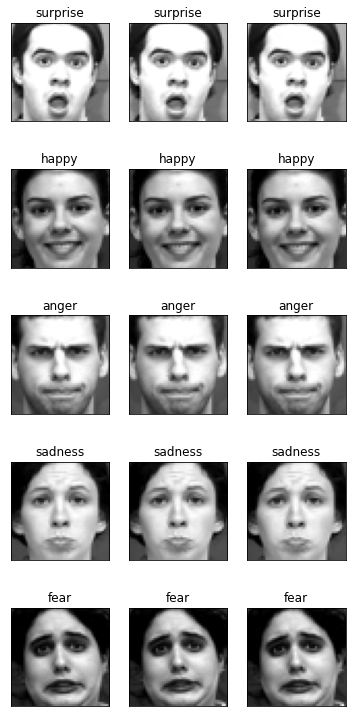

In [11]:
np.random.seed(42)
surprise_idx = np.random.choice(np.where(y_train[:, 0]==1)[0], size=1)
happy_idx = np.random.choice(np.where(y_train[:, 1]==1)[0], size=1)
anger_idx = np.random.choice(np.where(y_train[:, 2]==1)[0], size=1)
sad_idx = np.random.choice(np.where(y_train[:, 3]==1)[0], size=1)
fear_idx = np.random.choice(np.where(y_train[:, 4]==1)[0], size=1)

fig = pyplot.figure(1, (6,13))

i = 0
for name, idx in zip(label_emotion_mapper.values(), [surprise_idx, happy_idx, anger_idx, sad_idx, fear_idx]):
    for j in range(3):
        i += 1
        ax = pyplot.subplot(5,3,i)
        sample_img = X_train[idx][0,j,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(name)

In [12]:
# data normalization
X_train = X_train / 255.
X_test = X_test / 255.

In [13]:
def build_convlstm(input_shape, num_class, show_summary=True):
    net = Sequential(name='ConvLSTM2D')

    net.add(
        ConvLSTM2D(
            filters=64,
            kernel_size=(3,3),
            input_shape=input_shape,
            return_sequences=True,
            recurrent_activation='hard_sigmoid',
            activation='tanh',
            padding='same',
            kernel_initializer='glorot_uniform',
            name='convlstm2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        ConvLSTM2D(
            filters=64,
            kernel_size=(3,3),
            input_shape=input_shape,
            return_sequences=True,
            recurrent_activation='hard_sigmoid',
            activation='tanh',
            padding='same',
            kernel_initializer='glorot_uniform',
            name='convlstm2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))

    net.add(
        MaxPooling3D(
            pool_size=(1, 2, 2),
            padding='same',
            name='maxpool3d_1'
        )
    )
    net.add(Dropout(0.3, name='dropout_1'))

    net.add(
        ConvLSTM2D(
            filters=128,
            kernel_size=(3,3),
            input_shape=input_shape,
            return_sequences=True,
            recurrent_activation='hard_sigmoid',
            activation='tanh',
            padding='same',
            kernel_initializer='glorot_uniform',
            name='convlstm2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        ConvLSTM2D(
            filters=128,
            kernel_size=(3,3),
            input_shape=input_shape,
            return_sequences=True,
            recurrent_activation='hard_sigmoid',
            activation='tanh',
            padding='same',
            kernel_initializer='glorot_uniform',
            name='convlstm2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))

    net.add(
        MaxPooling3D(
            pool_size=(1, 2, 2),
            padding='same',
            name='maxpool3d_2'
        )
    )
    net.add(Dropout(0.3, name='dropout_2'))

    net.add(
        ConvLSTM2D(
            filters=256,
            kernel_size=(3,3),
            input_shape=input_shape,
            return_sequences=True,
            recurrent_activation='hard_sigmoid',
            activation='tanh',
            padding='same',
            kernel_initializer='glorot_uniform',
            name='convlstm2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        ConvLSTM2D(
            filters=256,
            kernel_size=(3,3),
            input_shape=input_shape,
            return_sequences=True,
            recurrent_activation='hard_sigmoid',
            activation='tanh',
            padding='same',
            kernel_initializer='glorot_uniform',
            name='convlstm2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))

    net.add(
        MaxPooling3D(
            pool_size=(1, 2, 2),
            padding='same',
            name='maxpool3d_3'
        )
    )
    net.add(Dropout(0.3, name='dropout_3'))
    
    net.add(TimeDistributed(Flatten(name="flatten")))
    
    net.add(
        TimeDistributed(
            Dense(
                64,
                activation='elu',
                kernel_initializer='he_normal',
                name='dense_1'
            )
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    net.add(Dropout(.6, name="dropout_4"))

    net.add(
        TimeDistributed(
            Dense(
                num_class,
                activation='softmax',
                name='out_layer'
            )
        )
    )

    if show_summary:
        net.summary()

    return net

In [14]:
y_train_ = np.empty((y_train.shape[0], 3, 5))
for i in range(y_train.shape[0]):
    y_train_[i] = np.tile(y_train[i], (3,1))
    
y_test_ = np.empty((y_test.shape[0], 3, 5))
for i in range(y_test.shape[0]):
    y_test_[i] = np.tile(y_test[i], (3,1))

In [15]:
y_train_.shape, y_test_.shape

((200, 3, 5), (50, 3, 5))

In [16]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.00005,
    patience=12,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
#     early_stopping,
    lr_scheduler,
]

batch_size = 8
epochs = 60

In [17]:
INPUT_SHAPE = (3, 48, 48, 1)
optim = optimizers.Adam(0.001)

model = build_convlstm(INPUT_SHAPE, num_class=5, show_summary=False)
model.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
)

In [18]:
history = model.fit(
    x=X_train,
    y=y_train_,
    validation_split=0.2,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True
)

Train on 160 samples, validate on 40 samples
Epoch 1/60
160/160 [==============================] - 19s 121ms/sample - loss: 2.5217 - accuracy: 0.2292 - val_loss: 1.5145 - val_accuracy: 0.4500
Epoch 2/60
160/160 [==============================] - 2s 15ms/sample - loss: 1.8655 - accuracy: 0.3958 - val_loss: 1.6330 - val_accuracy: 0.2167
Epoch 3/60
160/160 [==============================] - 2s 15ms/sample - loss: 1.2474 - accuracy: 0.5813 - val_loss: 1.7223 - val_accuracy: 0.4500
Epoch 4/60
160/160 [==============================] - 2s 15ms/sample - loss: 0.8515 - accuracy: 0.7188 - val_loss: 1.8266 - val_accuracy: 0.4500
Epoch 5/60
160/160 [==============================] - 3s 16ms/sample - loss: 0.8310 - accuracy: 0.7396 - val_loss: 2.0462 - val_accuracy: 0.3250
Epoch 6/60
160/160 [==============================] - 2s 15ms/sample - loss: 0.6559 - accuracy: 0.7521 - val_loss: 2.1448 - val_accuracy: 0.4500
Epoch 7/60
160/160 [==============================] - 2s 15ms/sample - loss: 0.5749

160/160 [==============================] - 2s 15ms/sample - loss: 0.0643 - accuracy: 0.9917 - val_loss: 0.2709 - val_accuracy: 0.8917
Epoch 53/60
160/160 [==============================] - 2s 15ms/sample - loss: 0.0617 - accuracy: 0.9937 - val_loss: 0.2667 - val_accuracy: 0.8917
Epoch 54/60
160/160 [==============================] - 2s 16ms/sample - loss: 0.0528 - accuracy: 0.9937 - val_loss: 0.2636 - val_accuracy: 0.8917
Epoch 55/60
160/160 [==============================] - 2s 15ms/sample - loss: 0.0422 - accuracy: 0.9979 - val_loss: 0.2619 - val_accuracy: 0.8917
Epoch 56/60
160/160 [==============================] - 2s 15ms/sample - loss: 0.0390 - accuracy: 0.9979 - val_loss: 0.2623 - val_accuracy: 0.8917
Epoch 57/60
152/160 [===========================>..] - ETA: 0s - loss: 0.0467 - accuracy: 1.0000
Epoch 00057: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
160/160 [==============================] - 2s 15ms/sample - loss: 0.0473 - accuracy: 1.0000 - val_loss: 0

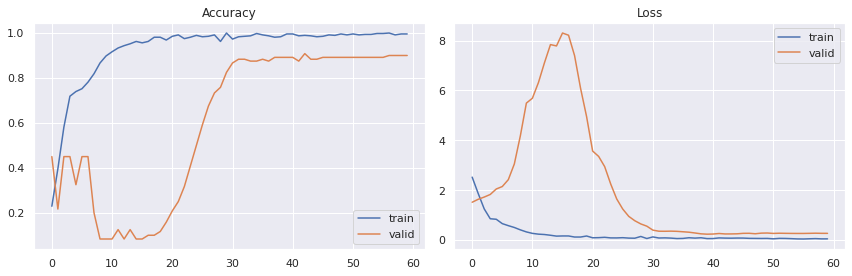

In [20]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history.png')
pyplot.show()